## import dependecies and load data

In [1]:
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error

import warnings

# Ignore warnings
warnings.filterwarnings("ignore")

In [2]:
# read the data, sheet_name=None so that all sheets are read
excel_data = pd.read_excel("strauss_ds_data.xlsx", sheet_name=None)

In [3]:
# save every sheet to a separate df
for sheet_name, df in excel_data.items():
    globals()[sheet_name] = df

merge holidays and events into sales:

In [4]:
#convert all date columns to datetime and tz_localize them
sales['sales_month'] = pd.to_datetime(sales['sales_month'])
holidays['date'] = pd.to_datetime(holidays['date'])
events['date'] = pd.to_datetime(events['date'])
sales['sales_month'] = sales['sales_month'].dt.tz_localize(None)

competitor_sales['date'] = pd.to_datetime(competitor_sales['date'])
competitor_sales['date'] = competitor_sales['date'].dt.tz_localize(None)

# merge sales / competitor sales with holidays and events
sales = pd.merge(sales, holidays, left_on='sales_month', right_on='date', how='left')
sales = pd.merge(sales, events, left_on='sales_month', right_on='date', how='left')

competitor_sales = pd.merge(competitor_sales, holidays, left_on='date', right_on='date', how='left')
competitor_sales = pd.merge(competitor_sales, events, left_on='date', right_on='date', how='left')

sales = sales.drop(['date_x', 'date_y'], axis=1)



## descriptive statistics

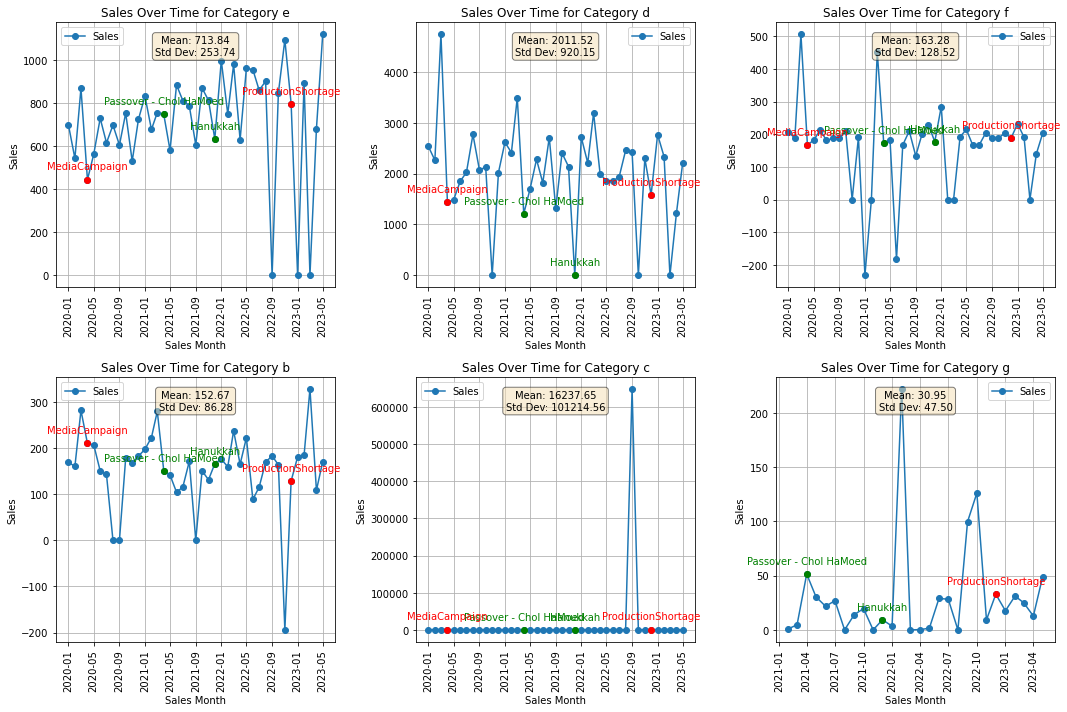

In [5]:
import pandas as pd
import matplotlib.pyplot as plt

# Assuming 'sales' dataframe is already prepared with 'holiday' and 'event_name' columns

# Get unique categories
categories = sales['category'].unique()

# Create subplots in a 2x3 grid (2 rows, 3 columns)
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(15, 10))

# Flatten the 2x3 subplot array to make it easier to iterate
axes = axes.flatten()

# Plot each category on a separate subplot
for i, category in enumerate(categories):
    category_data = sales[sales['category'] == category]

    # Plot sales data
    axes[i].plot(category_data['sales_month'], category_data['sales'], marker='o', linestyle='-', label='Sales')

    # Highlight holidays in green with annotations
    for index, row in category_data.iterrows():
        if not pd.isna(row['holiday']):
            axes[i].plot(row['sales_month'], row['sales'], 'go')  # Mark in green
            axes[i].annotate(row['holiday'], 
                             (row['sales_month'], row['sales']),
                             textcoords="offset points",
                             xytext=(0,10),
                             ha='center', color='green')

    # Highlight events in red with annotations
    for index, row in category_data.iterrows():
        if not pd.isna(row['event_name']):
            axes[i].plot(row['sales_month'], row['sales'], 'ro')  # Mark in red
            axes[i].annotate(row['event_name'], 
                             (row['sales_month'], row['sales']),
                             textcoords="offset points",
                             xytext=(0,10),
                             ha='center', color='red')

    # Display mean and standard deviation
    mean_value = category_data['sales'].mean()
    std_dev = category_data['sales'].std()

    axes[i].annotate(f'Mean: {mean_value:.2f}\nStd Dev: {std_dev:.2f}', 
                     xy=(0.5, 0.95), 
                     xycoords='axes fraction',
                     ha='center',
                     va='top',
                     bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

    axes[i].set_title(f'Sales Over Time for Category {category}')
    axes[i].set_xlabel('Sales Month')
    axes[i].set_ylabel('Sales')
    axes[i].grid(True)
    axes[i].legend()

    # Rotate x-axis ticks by 90 degrees
    axes[i].tick_params(axis='x', rotation=90)

# Adjust layout to prevent overlapping
plt.tight_layout()
plt.show()


These plots tell us a whole lot about the data.
some things we can learn: 
1. We can see that every category has a completely different range of values and therefore they should probably be modelled separately
2. The sales seem to be stationary, I don't see any sign of a trend. This tells us that the ARIMA model can probably be used successfully.
3. Category 'c' has a very extreme oulying observation, this must be somekind of typing mistake and I will remove it from the data. 
4. The holidays and events don't seem to have anything to do with the sales. with more time I would probably look at arange around every holiday/event and not just at the date itself, maybe something useful can come out of that. 

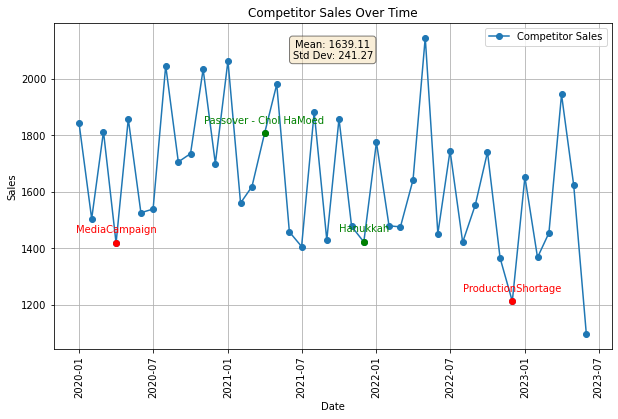

In [6]:
import pandas as pd
import matplotlib.pyplot as plt

# Assuming 'competitor_sales' dataframe is already prepared with 'holiday' and 'event_name' columns

# Create a subplot
fig, ax = plt.subplots(figsize=(10, 6))

# Plot competitor sales data
ax.plot(competitor_sales['date'], competitor_sales['sales'], marker='o', linestyle='-', label='Competitor Sales')

# Highlight holidays in green with annotations
for index, row in competitor_sales.iterrows():
    if not pd.isna(row['holiday']):
        ax.plot(row['date'], row['sales'], 'go')  # Mark in green
        ax.annotate(row['holiday'], 
                    (row['date'], row['sales']),
                    textcoords="offset points",
                    xytext=(0,10),
                    ha='center', color='green')

# Highlight events in red with annotations
for index, row in competitor_sales.iterrows():
    if not pd.isna(row['event_name']):
        ax.plot(row['date'], row['sales'], 'ro')  # Mark in red
        ax.annotate(row['event_name'], 
                    (row['date'], row['sales']),
                    textcoords="offset points",
                    xytext=(0,10),
                    ha='center', color='red')

# Display mean and standard deviation
mean_value = competitor_sales['sales'].mean()
std_dev = competitor_sales['sales'].std()

ax.annotate(f'Mean: {mean_value:.2f}\nStd Dev: {std_dev:.2f}', 
            xy=(0.5, 0.95), 
            xycoords='axes fraction',
            ha='center',
            va='top',
            bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

ax.set_title('Competitor Sales Over Time')
ax.set_xlabel('Date')
ax.set_ylabel('Sales')
ax.grid(True)
ax.legend()

# Rotate x-axis ticks by 90 degrees
ax.tick_params(axis='x', rotation=90)

plt.show()


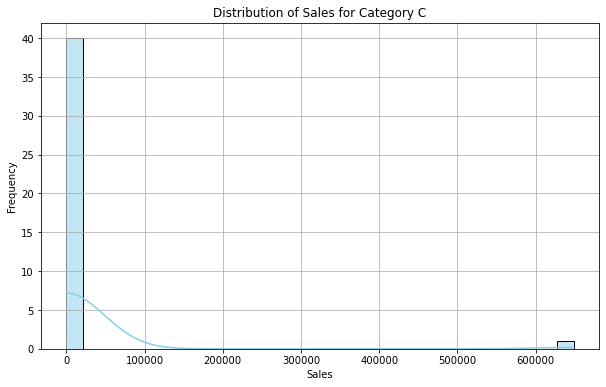

In [7]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming 'sales' dataframe is already prepared

# Select data for category 'c'
category_c_data = sales[sales['category'] == 'c']

# Plot histogram
plt.figure(figsize=(10, 6))
sns.histplot(category_c_data['sales'], bins=30, kde=True, color='skyblue')
plt.title('Distribution of Sales for Category C')
plt.xlabel('Sales')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()


## Further analysis and modelling

I have decided to replace the outlier with the mean of that category

In [8]:
mean_without_outlier = sales[sales['category']=='c']['sales'][sales[sales['category']=='c']['sales']<100000].mean()

In [9]:
sales.loc[(sales['category'] == 'c') & (sales['sales_month'] == '2022-09-01'), 'sales'] = mean_without_outlier

I should probably merge the sales and competitor sales... the competitor sales might be useful for modelling

In [10]:
sales_merged = sales.merge(competitor_sales, left_on='sales_month', right_on='date').drop(['date', 'holiday_y', 'event_name_y'], axis=1).rename(columns={'sales_x':'sales', 'holiday_x':'holiday', 'event_name_x':'event_name', 'sales_y':'competitor_sales'})

create some useful features:

In [11]:
sales_merged['is_holiday'] = sales_merged['holiday'].notna().astype(int)
sales_merged['is_ProductionShortage'] = (sales_merged['event_name'] == 'ProductionShortage').astype(int)
sales_merged['is_MediaCampaign'] = (sales_merged['event_name'] == 'MediaCampaign').astype(int)


In [12]:
# Convert 'sales_month' to datetime format
sales_merged['sales_month'] = pd.to_datetime(sales_merged['sales_month'])

# Extract year and month features
sales_merged['year'] = sales_merged['sales_month'].dt.year
sales_merged['month'] = sales_merged['sales_month'].dt.month


For this time-series forecasting task, I opted for the ARIMA (AutoRegressive Integrated Moving Average) model. ARIMA is a classic and fundamental approach for time-series prediction, known for its simplicity and effectiveness. The model combines autoregressive (AR) and moving average (MA) components while handling seasonality through differencing.

In a more comprehensive analysis, one might explore advanced models such as SARIMA (Seasonal ARIMA) or machine learning techniques like LSTM (Long Short-Term Memory) networks or Prophet. However, due to the constraints of the home exam and time limitations, I chose ARIMA as a solid starting point. In a real-world scenario with more time and resources, experimenting with these alternative models could provide a more nuanced understanding of the data and potentially improve forecasting accuracy.


For every category will will model the time-series using the ARIMA model. 
I have chosen to train on the dates up to december 22 and test on the dates from JAN 23 to May 23. 
I've added a loop to optimize the ARIMA order parameters over a small set of values (1-4) and choose the one which gives the best MSE. 

sales forcast function:

In [13]:
import pandas as pd
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt

# Assuming 'sales_merged' is your merged dataframe

# Select a product category ('category') for modeling
def sales_forcast_function(category):
    category_to_model = category
    category_data = sales_merged[sales_merged['category'] == category_to_model]

    # Chronological split
    split_date_train = '2022-12-01'
    split_date_test = '2023-01-01'
    split_date_future = '2023-06-01'

    # Separate data into training, testing, and future periods
    train_data = category_data[category_data['sales_month'] < split_date_train]
    test_data = category_data[(category_data['sales_month'] >= split_date_test) & (category_data['sales_month'] < split_date_future)]

    # Separate data into features and target
    X_train = train_data[['is_holiday', 'is_ProductionShortage', 'is_MediaCampaign', 'month', 'year', 'competitor_sales']]
    y_train = train_data['sales']
    X_test = test_data[['is_holiday', 'is_ProductionShortage', 'is_MediaCampaign', 'month', 'year', 'competitor_sales']]
    y_test = test_data['sales']

    best_mse = float('inf')
    best_order = None

    # Loop through different orders and select the best one
    for p in range(1, 4):  # You can adjust the range based on your preferences
        for d in range(1, 4):
            for q in range(1, 4):
                order = (p, d, q)
                
                # Fit ARIMA model
                arima_model = ARIMA(y_train, order=order)
                arima_result = arima_model.fit()

                # Make predictions for the testing period
                predictions_test = arima_result.predict(start=len(y_train), end=len(y_train) + len(y_test) - 1, typ='levels')

                # Evaluate the model for the testing period
                mse_test = mean_squared_error(y_test, predictions_test)

                # Check if this order gives a better result
                if mse_test < best_mse:
                    best_mse = mse_test
                    best_order = order

    # Fit the best ARIMA model
    arima_model = ARIMA(y_train, order=best_order)
    arima_result = arima_model.fit()

    # Make predictions for the testing period
    predictions_test = arima_result.predict(start=len(y_train), end=len(y_train) + len(y_test) - 1, typ='levels')

    # Visualize the best model's predictions for the testing period
    plt.figure(figsize=(12, 6))
    plt.plot(category_data['sales_month'], category_data['sales'], label='Actual')
    plt.plot(test_data['sales_month'], predictions_test, label=f'Best Predicted (Order={best_order})', color='red')
    plt.title(f'Best ARIMA Predictions for Category {category_to_model} - Testing Period')
    plt.xlabel('Time')
    plt.ylabel('Sales')
    plt.legend()
    plt.show()

    # Make predictions for the future period
    n_months_future = 6
    predictions_future = arima_result.predict(start=len(category_data), end=len(category_data) + n_months_future - 1, typ='levels')



    print(f'Best ARIMA Order: {best_order}')
    print(f'Mean Squared Error for Testing Period: {best_mse}')

    # Print predicted values
    print("\nPredicted Values:")
    print(predictions_test)
    print(predictions_future)


category b:

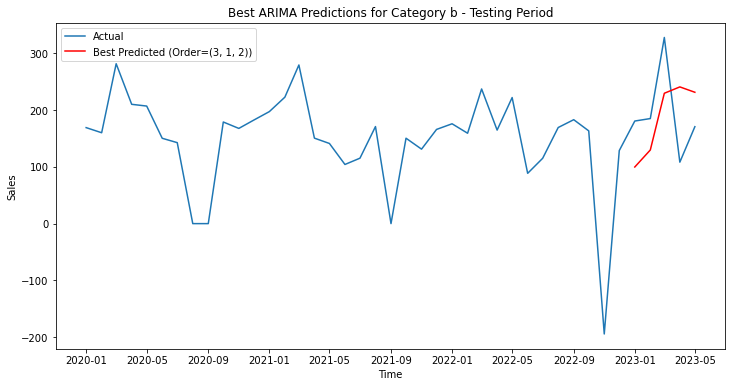

Best ARIMA Order: (3, 1, 2)
Mean Squared Error for Testing Period: 8092.641588410809

Predicted Values:
35     99.650591
36    129.608799
37    229.432296
38    240.617892
39    231.182679
Name: predicted_mean, dtype: float64
41    148.336190
42    112.735577
43     93.630669
44     91.103597
45    101.272059
46    117.452218
Name: predicted_mean, dtype: float64


In [14]:
sales_forcast_function('b')

category c:

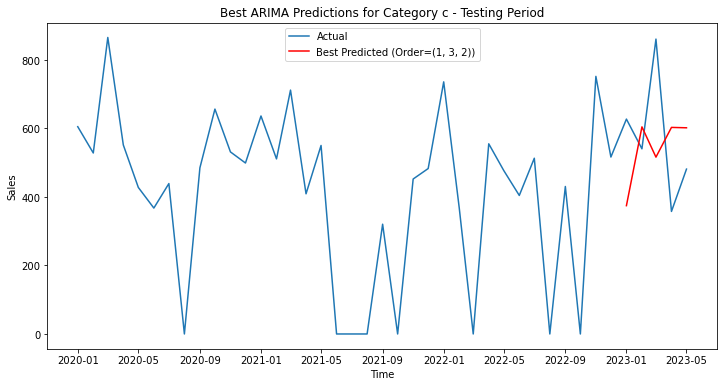

Best ARIMA Order: (1, 3, 2)
Mean Squared Error for Testing Period: 52302.356117215226

Predicted Values:
35    374.638377
36    604.687157
37    516.339843
38    603.135968
39    602.010563
Name: predicted_mean, dtype: float64
41    681.910842
42    728.034854
43    770.319990
44    820.084215
45    871.294862
46    927.167445
Name: predicted_mean, dtype: float64


In [15]:
sales_forcast_function('c')

category d:

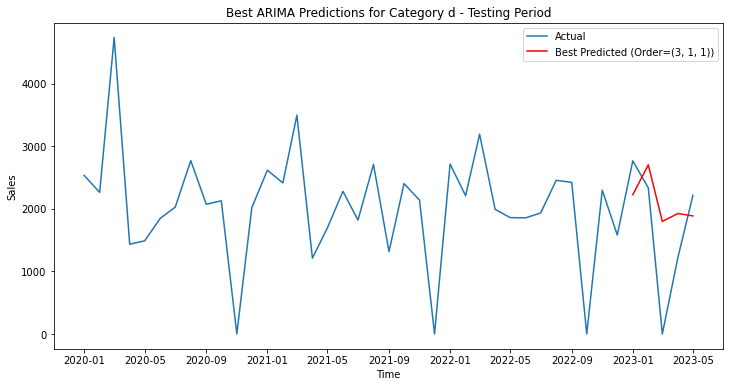

Best ARIMA Order: (3, 1, 1)
Mean Squared Error for Testing Period: 853877.0640523486

Predicted Values:
35    2225.046196
36    2702.921461
37    1798.008259
38    1924.872247
39    1886.692915
Name: predicted_mean, dtype: float64
41    2093.863093
42    2074.180494
43    1985.762950
44    2043.416126
45    2054.165079
46    2073.457275
Name: predicted_mean, dtype: float64


In [16]:
sales_forcast_function('d')

category e:

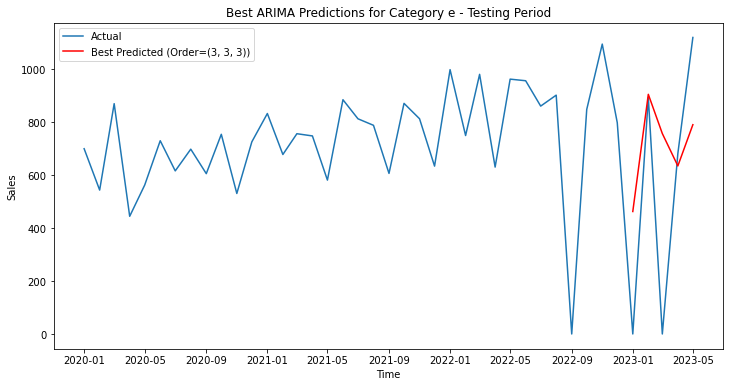

Best ARIMA Order: (3, 3, 3)
Mean Squared Error for Testing Period: 179635.2068432077

Predicted Values:
35    462.613026
36    905.315971
37    757.128545
38    634.809211
39    790.569197
Name: predicted_mean, dtype: float64
41    661.894183
42    653.565481
43    589.212716
44    589.019217
45    548.889801
46    512.185413
Name: predicted_mean, dtype: float64


In [17]:
sales_forcast_function('e')

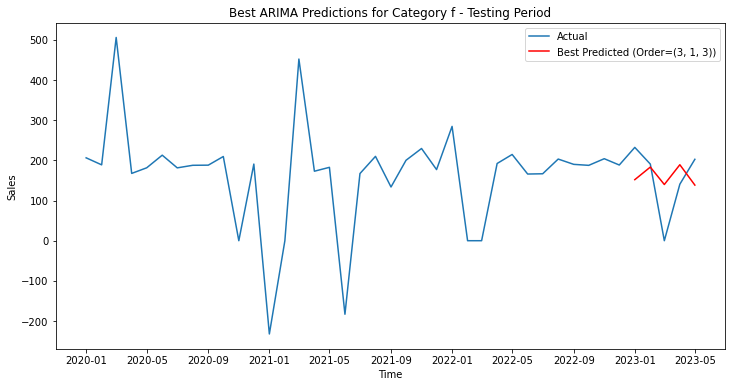

Best ARIMA Order: (3, 1, 3)
Mean Squared Error for Testing Period: 6510.409686250305

Predicted Values:
35    151.947156
36    183.293422
37    139.874027
38    189.113691
39    138.421526
Name: predicted_mean, dtype: float64
41    144.662783
42    177.462134
43    155.355597
44    166.038897
45    166.535736
46    155.963381
Name: predicted_mean, dtype: float64


In [18]:
sales_forcast_function('f')

category g:

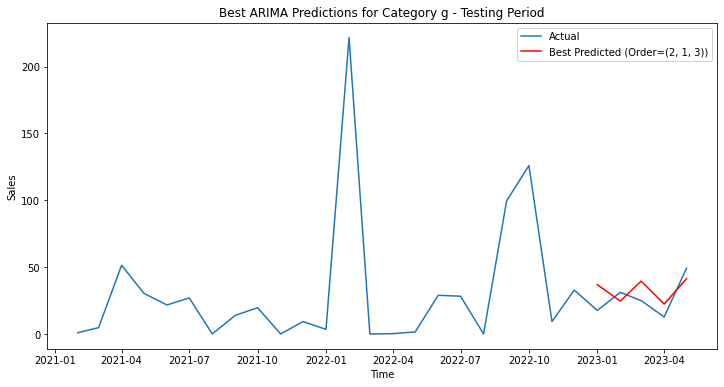

Best ARIMA Order: (2, 1, 3)
Mean Squared Error for Testing Period: 156.56111817938344

Predicted Values:
22    36.895463
23    24.617780
24    39.566790
25    22.419889
26    41.340551
Name: predicted_mean, dtype: float64
28    42.399189
29    20.263967
30    42.897474
31    19.995653
32    42.965471
33    20.100958
Name: predicted_mean, dtype: float64


In [19]:
sales_forcast_function('g')

The forcasting doesn't look great. 
This can probably be improved with:
1. Getting more data (more dates)
2. Having more explanatory variables
3. Optimizing model parameters

## Part 2

Dimensionality reduction in cases where there are many explanatory variables:
1. PCA: PCA is a linear dimensionality reduction technique that transforms the original variables into a new set of uncorrelated variables called principal components. These components are ordered by the amount of variance they explain in the data. By selecting a subset of the top principal components, you can retain most of the important information in the data while reducing its dimensionality.
2. t-SNE: t-SNE is a non-linear dimensionality reduction technique that is particularly useful for visualizing high-dimensional data in two or three dimensions. It focuses on preserving the local structure of the data, meaning that similar instances in the high-dimensional space are represented as nearby points in the low-dimensional space. t-SNE is often used for exploratory data analysis and visualization.
3. Autoencoders:  Autoencoders are a type of artificial neural network used for unsupervised learning. They consist of an encoder and a decoder, and the network is trained to reconstruct its input. The bottleneck layer in the middle represents a compressed representation of the input data, effectively reducing its dimensionality. Autoencoders can capture non-linear relationships in the data and are particularly useful when dealing with complex, high-dimensional datasets.

Dimensionality reduction in cases where there are many observations in sensory data:
1. ICA: ICA is a technique that aims to separate a multivariate signal into additive, independent components. In the context of sensory data, it can be used to identify and extract underlying sources or features that contribute to the observed signals. ICA is particularly useful when the sources are statistically independent, which is a common assumption in sensory data.
2. Random projection: Random projection is a simple and computationally efficient technique for reducing dimensionality. It involves projecting high-dimensional data onto a lower-dimensional subspace using a random matrix. Despite its simplicity, random projection has been shown to preserve pairwise distances reasonably well, making it a suitable option for large datasets, such as those often encountered in sensory data.
3. Incremental PCA: Incremental PCA is an extension of PCA that allows you to perform dimensionality reduction on large datasets that may not fit into memory. Instead of processing the entire dataset at once, incremental PCA processes the data in smaller batches. This makes it suitable for scenarios where there are many observations, and it can be more computationally efficient than traditional PCA, especially in cases with limited computational resources.

Before we deploy a model to production we should ask ourselves: 
1. Is the model suitable? does it work well enough?
2. Is it scalable? will it be able to handle large amounts of data?
3. Can the model give predictions in a reasonable time?
4. Will there be a data drift in production?
5. Does the model ensure the security and privacy of the users?
6. Are we able to monitor the performance in production?

Stages of deploying a model to production:
1. Data preparation
2. Pacage the model in a format that can be deployed
3. Deploy
4. Test for scalability 
5. Monitor the performance
6. Establish CI/CD pipelines

Important to monitor after deployment:
1. Accuracy
2. Prediction time - is the model working fast enough?
3. Resource usage
4. Data drift
5. Errors / logs

CI/CD tools:
I have experience with Kubernetes and CircleCI